In [1]:
from matplotlib import pyplot as plt
import numpy as np
from fedhex.io import RootLoader
from fedhex.train.tf import MADE, compile_MADE_model, load_MADE, train, MADE, MADEManager
from fedhex.utils import Checkpointer, SelectiveProgbarLogger, print_msg

2023-08-22 12:01:13.153291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Make a data loader instance for .ROOT files in the specified directory
root_path = "./root/10x10box_10k_jun2023/"
loader = RootLoader(root_path)

In [3]:
# Load training data from .ROOT files in specified dir; data are preprocessed
d = loader.load(event_thresh=100, epsilon=0.1)

12:01:15.50 <W> --- ./root/10x10box_10k_jun2023//Phi_1870_omega_9p025/2023-06-
12-11-54-06/v1p0-78-8cf4/ATTOAODv1p2c2_0.root: empty file ---


In [4]:
# Load preprocessed training data
data = loader.get_data()
cond = loader.get_cond()
print(data.shape, cond.shape)

(47665, 2) (47665, 2)


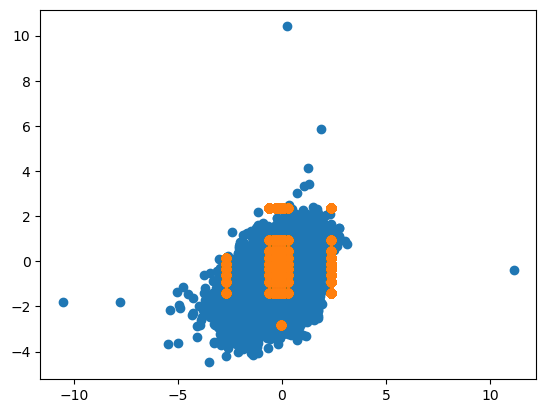

In [5]:
# Plot preprocessed training data
plt.scatter(data[:, 0], data[:, 1])
plt.scatter(cond[:, 0], cond[:, 1])

In [6]:
# Recover training samples from preprocessed network-friendly data
samples, labels = loader.recover_preproc()

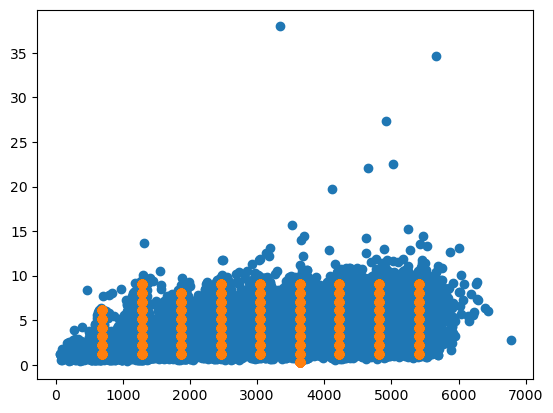

In [7]:
# Plot samples (blue) and labels (orange)
plt.scatter(samples[:, 0], samples[:, 1])
plt.scatter(labels[:, 0], labels[:, 1])

In [8]:
# Model parameters
num_made = 5
num_inputs = 2
num_cond_inputs = 2
hidden_layers = 1
hidden_units = 128
lr_start = 1e-3
lr_end = 1e-4
lr_decay_steps = 100
lr_tuple = (lr_start, lr_end, lr_decay_steps)

# Create MADEManager instance with all parameters needed to build model
mm = MADEManager(nmade=num_made, ninputs=num_inputs, ncinputs=num_cond_inputs,
                 hidden_layers=hidden_layers, hidden_units=hidden_units,
                 lr_tuple=lr_tuple)

# Build model
mm.compile_model()

In [9]:
# Train parameters
nepochs = 200
batch_size = 1024
starting_epoch = 0
flow_path = "./model/08-11_OOP1/"

# Make callbacks
callbacks = []
t = print_msg("Beginning Training")
callbacks.append(SelectiveProgbarLogger(verbose=1, epoch_interval=10, epoch_end=nepochs, tstart=t))
callbacks.append(Checkpointer(flow_path + "{epoch:03}.ckpt", save_freq=50 * nepochs))

# Run training procedure
mm.train_model(data=data, cond=cond, nepochs=nepochs, batch_size=batch_size,
               starting_epoch=starting_epoch, flow_path=flow_path,
               callbacks=callbacks)

epoch begin: 2023-08-22 12:01:38.588713 | time elapsed: 0:00:07.511884
Epoch 10/200
47/47 [==============================] - 0s 9ms/sample - loss: 1.9714
epoch begin: 2023-08-22 12:01:42.509172 | time elapsed: 0:00:11.432343
Epoch 20/200
47/47 [==============================] - 0s 9ms/sample - loss: 1.1835
epoch begin: 2023-08-22 12:01:46.458957 | time elapsed: 0:00:15.382128
Epoch 30/200
47/47 [==============================] - 0s 9ms/sample - loss: 0.8693
epoch begin: 2023-08-22 12:01:50.508689 | time elapsed: 0:00:19.431860
Epoch 40/200
47/47 [==============================] - 0s 9ms/sample - loss: 0.6565
epoch begin: 2023-08-22 12:01:54.579234 | time elapsed: 0:00:23.502405
Epoch 50/200
47/47 [==============================] - 0s 11ms/sample - loss: 0.5130
epoch begin: 2023-08-22 12:01:58.748026 | time elapsed: 0:00:27.671197
Epoch 60/200
47/47 [==============================] - 0s 9ms/sample - loss: 0.4226
epoch begin: 2023-08-22 12:02:02.905850 | time elapsed: 0:00:31.829021
Epoc

INFO:tensorflow:Assets written to: ./model/08-11_OOP1/assets


INFO:tensorflow:Assets written to: ./model/08-11_OOP1/assets


In [10]:
# Setup sample generation for a known training label
ngen = 500
gen_label = np.array([2464, 5.125])
gen_labels = np.repeat([gen_label], ngen, axis=0)
gen_cond = loader.preproc_new(samples=gen_labels, is_cond=True)

# Generate data for the provided conditional data
gen_data = mm.eval_model(gen_cond)
gen_samples = loader.recover_new(gen_data)

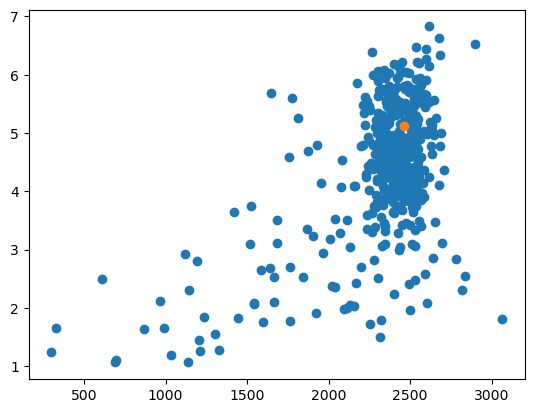

In [11]:
# Plot generated samples for the known training label
plt.scatter(gen_samples[:, 0], gen_samples[:, 1])
plt.scatter(gen_label[0], gen_label[1])

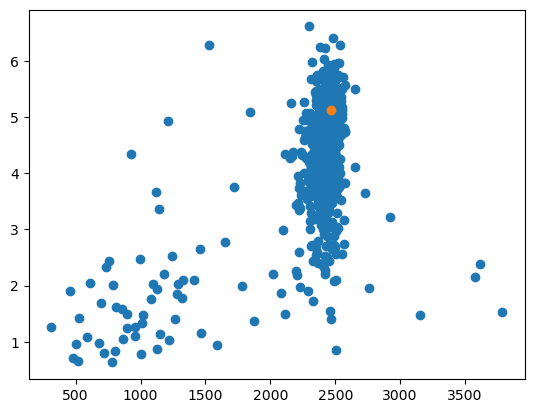

In [12]:
# Determine unique labels that are shared by both training and generated data
labels_unique, inverse_unique = np.unique(labels, return_inverse=True, axis=0)
samples_temp = [samples[inverse_unique == i] for i in range(len(labels_unique)) if np.array_equiv(labels_unique[i], gen_label)][0]

# Plot training sample that will be compared to generated data
plt.scatter(samples_temp[:, 0], samples_temp[:, 1])
plt.scatter(gen_label[0], gen_label[1])


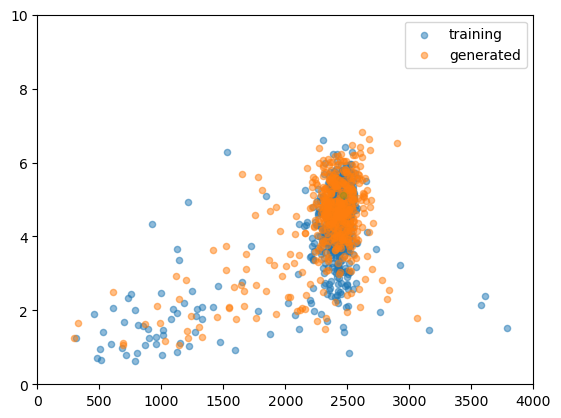

In [13]:
# Plot training and generated data on top of each other
plt.scatter(samples_temp[:, 0], samples_temp[:, 1], alpha=0.5, s=20, label="training")
plt.scatter(gen_samples[:, 0], gen_samples[:, 1], alpha=0.5, s=20, label="generated")
plt.scatter(gen_label[0], gen_label[1], alpha=0.25, s=20)
plt.xlim((0.0, 4000.0))
plt.ylim((0.0, 10.0))
plt.legend()

In [14]:
# test network
# - do we get what we put in?
# - does it interpolate well?
# - if we step up num generated, when do we start losing quality?
# - mess with hyper params, optimize those for MADEflow
# - try other architectures, i.e., RealNVP